<h2>Import libraries:</h2>

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

<h2>Pytorch dataset:</h2>

In [ ]:
# Pytorch dataset that is needed for Trainer function
class EmotionDataset(Dataset):

    # initialize the dataset
    def __init__(self, encodings, labels):
        label_mapping = {"joy": 0, "sadness": 1, "anger": 2, "love": 3, "fear": 4, "surprise": 5}
        self.encodings = encodings
        self.labels = [label_mapping[label] for label in labels]  # Map labels to integers

    # get the number of classification labels
    def __len__(self):
        return len(self.labels)

    # get an item in the
    def __getitem__(self, idx):
        item = {key: val[idx].clone() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

<h2>Function to get the training data + labels:</h2>

In [ ]:
def split_text_data(f):
    corpus = []
    labels = []
    with open(f, 'r') as file:
        for line in file:
            contents = line.split(';')
            corpus.append(contents[0].strip())
            labels.append(contents[1].strip())
    return corpus, labels

<h2>Get tokenizer and tokenize the sentences to create PyTorch dataset: </h2>

In [ ]:
# get tokenizer so that BERT can properly process the data
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# split the text data into class labels and features to be transferred into numerical values to be trained on
corpus_train, labels_train = split_text_data('./train.txt')
train_encodings = tokenizer(
    corpus_train,
    padding="max_length",      # Pad sequences to the maximum length
    truncation=True,           # Truncate sequences longer than max_length
    max_length=128,            # Set max length to 128 tokens
    return_tensors="pt",       # Return PyTorch tensors (use "tf" for TensorFlow)
    add_special_tokens=True,   # Add special tokens [CLS], [SEP]
    return_attention_mask=True # Return attention mask
)
train_dataset = EmotionDataset(train_encodings, labels_train)

# split the text data into class labels and features to be transferred into numerical values to be validated on
corpus_val, labels_val = split_text_data('./val.txt')
valid_encodings = tokenizer(
    corpus_val,
    padding="max_length",      # Pad sequences to the maximum length
    truncation=True,           # Truncate sequences longer than max_length
    max_length=128,            # Set max length to 128 tokens
    return_tensors="pt",       # Return PyTorch tensors (use "tf" for TensorFlow)
    add_special_tokens=True,   # Add special tokens [CLS], [SEP]
)
valid_dataset = EmotionDataset(valid_encodings, labels_val)

# split the text data into class labels and features to be transferred into numerical values to be tested on
corpus_test, labels_test = split_text_data('./test.txt')
test_encodings = tokenizer(
    corpus_test,
    padding="max_length",      # Pad sequences to the maximum length
    truncation=True,           # Truncate sequences longer than max_length
    max_length=128,            # Set max length to 128 tokens
    return_tensors="pt",       # Return PyTorch tensors (use "tf" for TensorFlow)
    add_special_tokens=True,   # Add special tokens [CLS], [SEP]
)
test_dataset = EmotionDataset(test_encodings, labels_test)

In [ ]:
# go through the labels of the training set and count how many of each class label
class_labels = {"joy": 0, "sadness": 0, "anger": 0, "love": 0, "fear": 0, "surprise": 0}
total = 0
for idx, label in enumerate(labels_train):
    class_labels[label] += 1
    total += 1

# find the percentages of each class in the training set
splits_train = []
for label, count in class_labels.items():
    print(f"{label}: {(count / total * 100):.0f}%")
    splits_train.append((count / total * 100))
print("-------------")
print()

# go through the labels of the validation set and count how many of each class label
class_labels = {"joy": 0, "sadness": 0, "anger": 0, "love": 0, "fear": 0, "surprise": 0}
total = 0
for idx, label in enumerate(labels_val):
    class_labels[label] += 1
    total += 1

# find the percentages of each class in the validation set
splits_val = []
for label, count in class_labels.items():
  print(f"{label}: {(count / total * 100):.0f}%")
  splits_val.append((count / total * 100))
print("-------------")
print()

# go through the labels of the testing set and count how many of each class label
class_labels = {"joy": 0, "sadness": 0, "anger": 0, "love": 0, "fear": 0, "surprise": 0}
total = 0
for idx, label in enumerate(labels_test):
    class_labels[label] += 1
    total += 1

splits_test = []
# find the percentages of each class in the testing set
for label, count in class_labels.items():
  print(f"{label}: {(count / total * 100):.0f}%")
  splits_test.append((count / total * 100))

joy: 34%
sadness: 29%
anger: 13%
love: 8%
fear: 12%
surprise: 4%
-------------

joy: 35%
sadness: 28%
anger: 14%
love: 9%
fear: 11%
surprise: 4%
-------------

joy: 35%
sadness: 29%
anger: 14%
love: 8%
fear: 11%
surprise: 3%


In [ ]:
import matplotlib.pyplot as plt

def plt_splits(splits, dataset):
  labels = ["joy", "sadness", "anger", "love", "fear", "surprise"]

  # Create the pie chart
  plt.figure(figsize=(8, 8))
  plt.pie(
      splits,
      labels=labels,
      autopct='%d%%',  # Show percentages with 1 decimal point
      startangle=140,     # Rotate the pie chart for better visualization
      colors=["gold", "skyblue", "lightcoral", "yellowgreen", "purple", "orange"]
  )

  # Add a title
  title = f"{dataset} Emotion Class Distribution"
  plt.title(title, fontsize=16)

  # Display the chart
  plt.show()

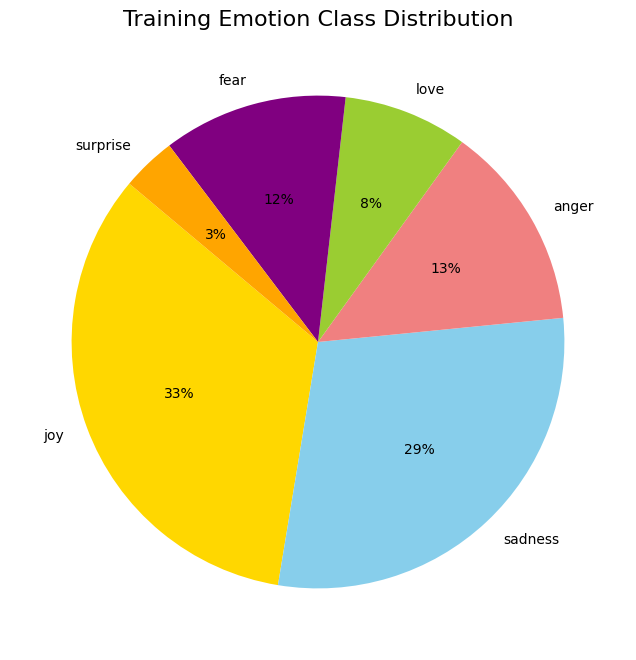

In [ ]:
plt_splits(splits_train, "Training")

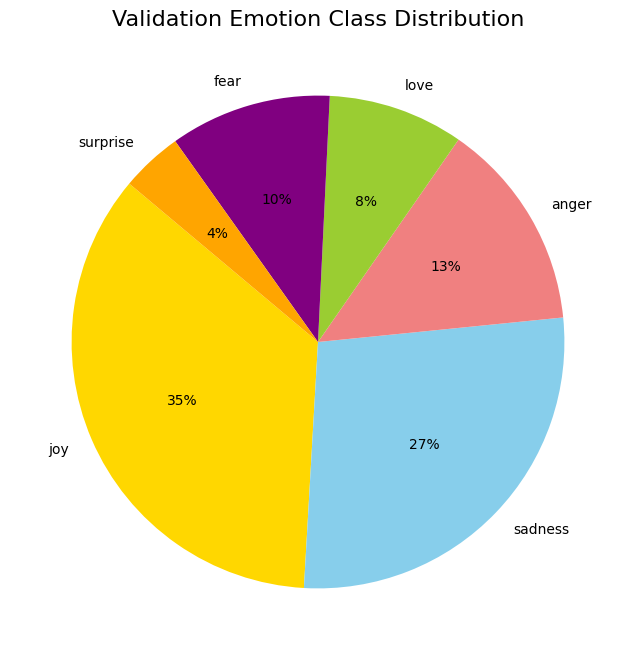

In [ ]:
plt_splits(splits_val, "Validation")

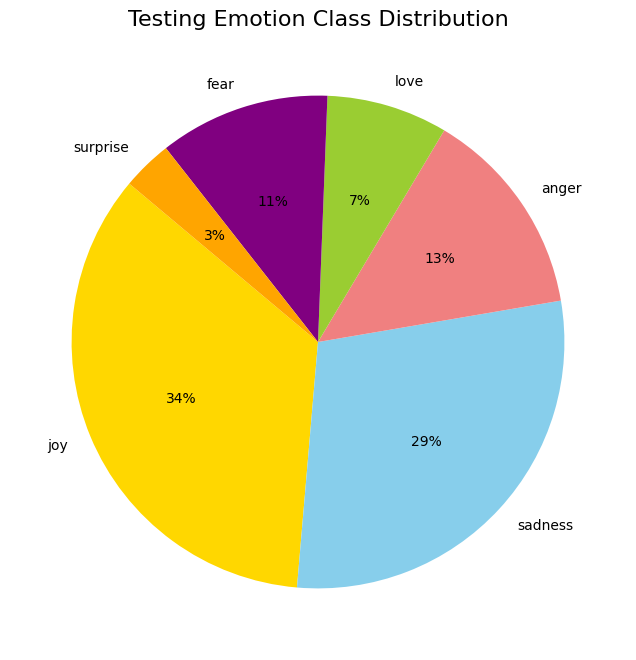

In [ ]:
plt_splits(splits_test, "Testing")

<h2> Get BERT model and train the model based on datasets processed:</h2>

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    seed=42
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()}
)

# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
50,1.525400
100,1.191000
150,0.872900
200,0.610800
250,0.560100
300,0.537000
350,0.421500
400,0.356300
450,0.431200
500,0.445600


TrainOutput(global_step=6000, training_loss=0.2161097481250763, metrics={'train_runtime': 1210.4461, 'train_samples_per_second': 39.655, 'train_steps_per_second': 4.957, 'total_flos': 3157446057984000.0, 'train_loss': 0.2161097481250763, 'epoch': 3.0})

<h2>Test the model with the test dataset:</h2>

In [ ]:
predictions = trainer.predict(test_dataset)

# Extract predictions and labels
pred_logits = predictions.predictions  # Raw logits
pred_labels = pred_logits.argmax(-1)   # Convert logits to predicted labels
print("Predicted Labels:", pred_labels)

# Compare with true labels
print("True Labels:", test_dataset.labels)

Predicted Labels: [1 1 1 ... 0 0 5]
True Labels: [1, 1, 1, 0, 1, 4, 2, 0, 0, 2, 4, 1, 4, 0, 3, 1, 0, 1, 2, 0, 1, 0, 0, 1, 1, 4, 2, 1, 4, 2, 4, 2, 1, 2, 1, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 2, 0, 0, 4, 4, 1, 4, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 1, 5, 1, 2, 4, 5, 0, 3, 5, 0, 3, 2, 0, 1, 0, 3, 0, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 4, 2, 4, 2, 2, 3, 1, 2, 1, 1, 1, 1, 4, 2, 2, 0, 0, 4, 1, 0, 3, 4, 0, 1, 0, 0, 4, 1, 0, 1, 0, 1, 2, 1, 3, 1, 4, 1, 1, 0, 3, 1, 2, 2, 0, 4, 2, 1, 0, 0, 1, 4, 0, 0, 1, 0, 4, 4, 3, 1, 3, 5, 1, 0, 1, 0, 0, 2, 1, 2, 2, 0, 4, 4, 0, 3, 3, 3, 1, 3, 2, 0, 0, 1, 2, 0, 0, 1, 1, 4, 0, 1, 3, 4, 1, 0, 0, 4, 2, 0, 1, 0, 2, 1, 1, 4, 4, 0, 0, 0, 3, 3, 0, 0, 0, 3, 4, 4, 0, 2, 1, 0, 4, 0, 1, 2, 1, 2, 2, 0, 4, 5, 0, 0, 0, 2, 0, 3, 4, 1, 1, 0, 0, 4, 0, 1, 0, 1, 0, 1, 3, 4, 0, 1, 1, 1, 2, 0, 5, 1, 1, 1, 2, 3, 1, 0, 0, 1, 2, 2, 2, 0, 2, 2, 3, 0, 0, 2, 1, 2, 2, 4, 1, 2, 1, 0, 4, 2, 1, 0, 1, 1, 0, 0, 0, 3, 1, 0, 0, 5, 4, 3, 1, 3, 4, 2, 1, 1, 2, 0, 2, 3, 3, 0, 4, 2, 3, 4, 4, 0, 1, 4, 0, 1, 2, 3,

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# True labels
true_labels = test_dataset.labels

# Predicted labels
predicted_labels = pred_labels.tolist()

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(true_labels, predicted_labels, average="weighted")
print("F1 Score:", f1)

Accuracy: 0.927
F1 Score: 0.9267209561828199


<h2>Save the model, tokenizer, and state of model into a directory:</h2>

In [ ]:
# Save the model and tokenizer
trainer.save_model("./BERT-emotion-detection-model")
tokenizer.save_pretrained("./BERT-emotion-detection-model")

# Save the trainer state
trainer.save_state()  # This saves the training state (optimizer, scheduler, etc.)

<h2>Download model from Colab into your computer for later use:</h2>

In [ ]:
import shutil

# Specify the folder path you want to download
folder_path = '/content/BERT-emotion-detection-model'

# Specify the destination path for the zipped file
zip_path = '/content/BERT-emotion-detection-model.zip'

# Zip the folder
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

'/content/BERT-emotion-detection-model.zip'

In [ ]:
from google.colab import files

# Download the zipped folder
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>